In [31]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [32]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.functional as FA
import torchaudio.transforms as TT
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

from torchvision.models import densenet121, resnext101_32x8d, mobilenet_v3_small, densenet169
import torch.optim as optim


In [34]:
num_epochs = 35
batch_size = 16
batch_size_val = batch_size
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'stftcrop'# 'stft', 'reassigned_stft', 'melstft'
modeltype = 'densenet121'#'resnext101' # 'resnet34','resnet152'

train_df = pd.read_parquet('../data_created/suzmel_train.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(lowcut=140, highcut=1500), RandomRoll() ,RandomFlip(), TransformWingbeat(setting=setting)]#, RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass(lowcut=140, highcut=1500), TransformWingbeat(setting=setting)]

X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

/home/kalfasyan/projects/wbai/Experiment-notebooks/../utils.py:296: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return (F.adaptive_avg_pool2d(Variable(img,volatile=True), size)).data


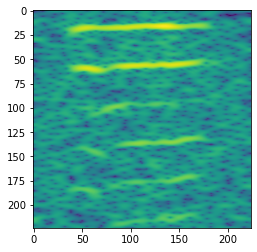

In [35]:
plt.imshow(train_dataset[0][0][0]);

In [36]:
outs=2
if modeltype in ['densenet121', 'densenet169']:
    if modeltype=='densenet121':
        model = densenet121(pretrained=False)
    elif modeltype=='densenet169':
        model = densenet169(pretrained=False)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,2)

elif modeltype == 'resnext101':
    model = resnext101_32x8d(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,2)
elif modeltype == 'mobilenet_v3_small':
    model = mobilenet_v3_small(pretrained=False)
    num_ftrs = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_ftrs,2)



class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(weight=torch.Tensor(weight))
elif outs == 2:
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Training

In [ ]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)
        if outs == 1:
            y_batch = y_batch.type(torch.FloatTensor).cuda()
            correct_train += ((pred>0.5).int().squeeze() == y_batch.squeeze()).float().sum().item()
            loss = criterion(pred, y_batch.unsqueeze(1))
        elif outs == 2:
            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
            loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        pred = model(x_batch)
        if outs == 1:
            y_batch = y_batch.type(torch.FloatTensor).cuda()
            correct_valid += ((pred>0.5).int().squeeze().cuda() == y_batch.squeeze()).float().sum().item()
            val_loss = criterion(pred, y_batch.unsqueeze(1))
        elif outs == 2:
            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()
#     early_stopping(val_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best)


Training..	:   0%|          | 0/1623 [00:00<?, ?it/s]

Train on gpu: True


Validating..	: 100%|██████████| 243/243 [02:30<00:00,  1.62it/s]


Epoch 0: train_acc: 84.0% loss: 0.5560706,  val_loss: 0.1004702 val_acc: 88.7%
Validation accuracy improved from 0.00 to 88.66. Saving model..


Validating..	: 100%|██████████| 243/243 [02:33<00:00,  1.58it/s]


Epoch 1: train_acc: 88.3% loss: 0.1327201,  val_loss: 0.0512637 val_acc: 90.2%
Validation accuracy improved from 88.66 to 90.16. Saving model..


Validating..	: 100%|██████████| 243/243 [02:34<00:00,  1.58it/s]


Epoch 2: train_acc: 90.0% loss: 0.3807528,  val_loss: 0.4213263 val_acc: 90.9%
Validation accuracy improved from 90.16 to 90.93. Saving model..


Training..	:  82%|████████▏ | 1331/1623 [14:17<02:01,  2.41it/s]

# DEBUG

In [30]:
results['val_loss'][0].detach().cpu()

1

## Testing on test set

In [ ]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_best.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

In [ ]:
_ = test_model(model,test_dataloader, test_dataset)

## Testing on extra mebios data

In [ ]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [ ]:
_ = test_model(model,extra_dataloader, extra_dataset)

In [133]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'stft'# 'stft', 'reassigned_stft', 'melstft'
modelname = 'densenet121' # 'resnet34','resnet152'

## Datasets and Dataloaders

In [134]:
transforms_list = [FilterWingbeat(setting='bandpass'), TransformWingbeat(setting=setting)]
# [FilterWingbeat(setting='bandpass'), NormalizeWingbeat(), TransformWingbeat(setting=setting)]

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], transform=transforms.Compose(transforms_list)).clean()
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/R",      custom_label=[1], transform=transforms.Compose(transforms_list)).clean()

Found 29002 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Nr. of valid wingbeats: 12819
Found 24763 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Nr. of valid wingbeats: 11778
Found 25732 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Nr. of valid wingbeats: 17088
Found 14348 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Nr. of valid wingbeats: 10372


In [135]:
transformed_dataset = ConcatDataset([dmel1, dsuz1])

train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset([dmel2, dsuz2])

In [136]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

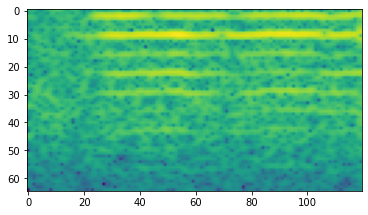

In [139]:
plt.imshow(train_dataset[5][0][0])

## Model definition

In [140]:
from torchvision.models import resnet34, densenet121, resnet152
import torch.optim as optim

if setting in ['stft', 'reassigned_stft', 'melstft']:
    if modelname == 'densenet121':
        model = densenet121(pretrained=False)
        num_ftrs = model.classifier.in_features
        model.fc = nn.Linear(num_ftrs,2)
    elif modelname in ['resnet34', 'resnet152']:
        model = densenet121(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,2)        

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=2)
# print(model)

## Training

In [141]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

Train on gpu: True


In [142]:
import warnings
warnings.filterwarnings("ignore")

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Validating..	: 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]


Validation loss decreased (inf --> 0.366545).  Saving model ...


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 0: train_acc: 82.39% loss: 0.413,  val_loss: 0.367 val_acc: 85.42%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Epoch 1: train_acc: 86.87% loss: 0.432,  val_loss: 0.426 val_acc: 85.80%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Validation loss decreased (0.366545 --> 0.351244).  Saving model ...
Epoch 2: train_acc: 88.26% loss: 0.588,  val_loss: 0.351 val_acc: 85.62%


Validating..	: 100%|██████████| 94/94 [00:03<00:00, 25.22it/s]


Validation loss decreased (0.351244 --> 0.341243).  Saving model ...


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 3: train_acc: 89.28% loss: 0.406,  val_loss: 0.341 val_acc: 86.22%


Validating..	: 100%|██████████| 94/94 [00:03<00:00, 26.04it/s]


Validation loss decreased (0.341243 --> 0.252364).  Saving model ...


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 4: train_acc: 90.17% loss: 0.378,  val_loss: 0.252 val_acc: 87.90%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Epoch 5: train_acc: 90.81% loss: 0.412,  val_loss: 0.301 val_acc: 86.09%


Validating..	: 100%|██████████| 94/94 [00:03<00:00, 24.52it/s]


Validation loss decreased (0.252364 --> 0.224945).  Saving model ...


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 6: train_acc: 91.52% loss: 0.525,  val_loss: 0.225 val_acc: 87.77%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Epoch 7: train_acc: 91.94% loss: 0.475,  val_loss: 0.356 val_acc: 84.28%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Epoch 8: train_acc: 92.56% loss: 0.365,  val_loss: 0.618 val_acc: 76.23%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7
Epoch 9: train_acc: 93.03% loss: 0.335,  val_loss: 0.278 val_acc: 86.84%


Validating..	: 100%|██████████| 94/94 [00:03<00:00, 25.17it/s]


Validation loss decreased (0.224945 --> 0.208396).  Saving model ...


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 10: train_acc: 93.21% loss: 0.290,  val_loss: 0.208 val_acc: 90.09%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Epoch 11: train_acc: 93.90% loss: 0.279,  val_loss: 0.656 val_acc: 77.36%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Epoch 12: train_acc: 94.35% loss: 0.273,  val_loss: 0.265 val_acc: 85.44%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7
Epoch 13: train_acc: 94.93% loss: 0.231,  val_loss: 0.375 val_acc: 86.09%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch    15: reducing learning rate of group 0 to 1.0000e-03.
EarlyStopping counter: 4 out of 7
Epoch 14: train_acc: 95.47% loss: 0.391,  val_loss: 0.468 val_acc: 86.59%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 5 out of 7
Epoch 15: train_acc: 95.94% loss: 0.356,  val_loss: 0.319 val_acc: 91.97%


Training..	:   0%|          | 0/748 [00:00<?, ?it/s]

EarlyStopping counter: 6 out of 7
Epoch 16: train_acc: 97.21% loss: 0.302,  val_loss: 0.366 val_acc: 91.74%


Validating..	: 100%|██████████| 94/94 [00:03<00:00, 26.12it/s]

EarlyStopping counter: 7 out of 7
Early stopping


In [143]:
# print(x_batch, y_batch)

## Testing

In [144]:
correct_test = 0
model.eval()
for x_batch,y_batch,path_batch,idx_batch in tqdm(test_dataloader, desc="Testing..\t"):

    y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
    x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

    pred = model(x_batch)
    val_loss = criterion(pred, y_batch)
    correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
print(test_accuracy)

Testing..	: 100%|██████████| 347/347 [00:48<00:00,  7.17it/s]

75.13508645533142


# SPEC AUGMENT

In [99]:
def tensor_to_img(spectrogram):
    plt.figure(figsize=(14,8)) # arbitrary, looks good on my screen.
    plt.imshow(spectrogram[0])
    plt.show();
    display(spectrogram.shape)

torch.Size([3, 128, 120])
<class 'torch.Tensor'>


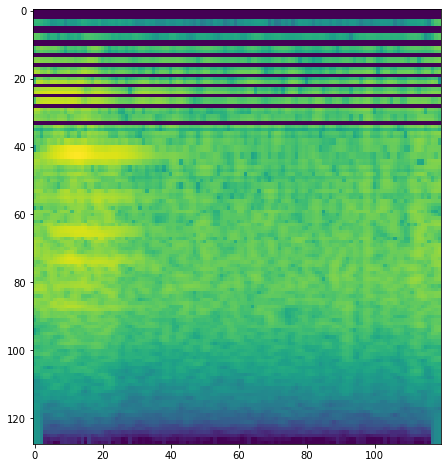

torch.Size([3, 128, 120])

In [100]:
spectro = train_dataset[11][0]
# spectro = spectro[0,:,:].numpy()
# spectro = torch.from_numpy(spectro)#np.expand_dims(spectro, axis=-1))
# spectro = np.stack((spectro,)*3, axis=-1)
print(spectro.shape)
print(type(spectro))
tensor_to_img(spectro)

## Time Warp

Time Warp is described as:
> Time warping is applied via the function sparse image warp of tensorflow. Given a log mel spectrogram with τ time steps, we view it as an image where the time axis is horizontal and the frequency axis is vertical. A random point along the horizontal line passing through the center of the image within the time steps (W, τ − W) is to be warped either to the left or right by a distance w chosen from a uniform distribution from 0 to the time warp parameter W along that line.

Intuitively we squish/stretch the audio in a given direction bounded by the `W` parameter we select.

NOTE:
`sparse_image_warp` does not exist in Pytorch, so you can see our implementation in the SparseImageWarp.ipynb notebook. Our implementation skips certain features like add clamping.

You should be careful with your `W` parameter because it's highly dependent on your audio and spectrogram. 

*Sanity check your spectrograms if you're using this transform.*

In [103]:
#Export
def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    device = spec.device
    
    y = num_rows//2
    horizontal_line_at_ctr = spec[0][y]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]
    assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = (torch.tensor([[[y, point_to_warp]]], device=device), 
                         torch.tensor([[[y, point_to_warp + dist_to_warp]]], device=device))
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)

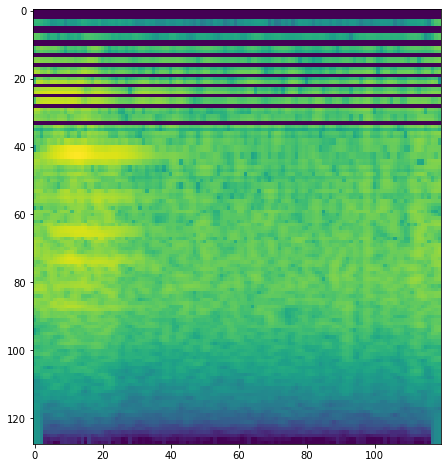

torch.Size([3, 128, 120])

RuntimeError: shape '[3, 128, 120, 2]' is invalid for input of size 30720

In [104]:
def test_time_warp():
    tensor_to_img(time_warp(spectro))
tensor_to_img(spectro)    
test_time_warp()

## Frequency Mask

Frequency masking is described as:
> Frequency masking is applied so that f consecutive mel
frequency channels [f0, f0 + f) are masked, where f is first chosen from a uniform distribution from 0 to the frequency mask parameter F, and f0 is chosen from 0, ν − f). ν is the number of mel frequency channels.

Intuitively, this is similar to cutout in computer vision workflows. We mask certain frequency bands with either the mean value of the spectrogram or zero.

In [105]:
#Export
def freq_mask(spec, F=30, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):        
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
        else: cloned[0][f_zero:mask_end] = cloned.mean()
    
    return cloned

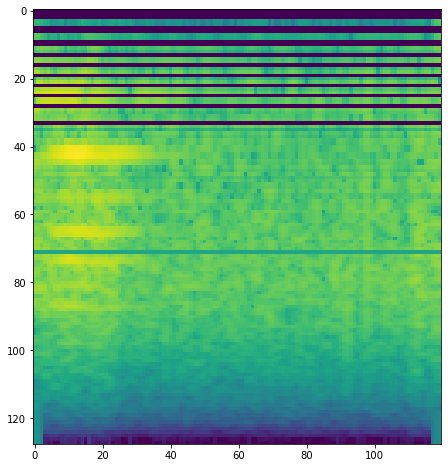

torch.Size([3, 128, 120])

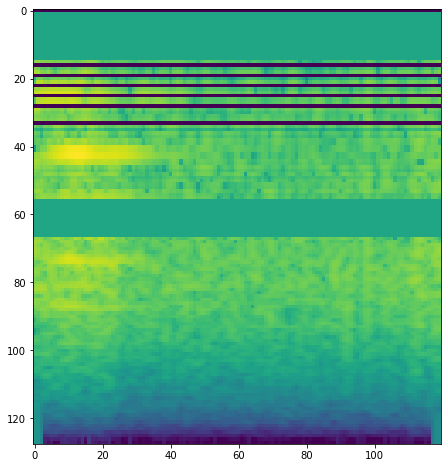

torch.Size([3, 128, 120])

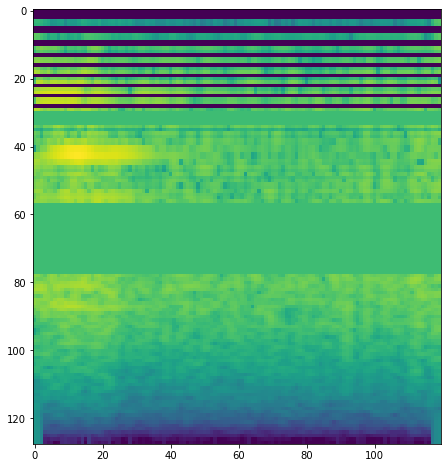

torch.Size([3, 128, 120])

In [106]:
def test_freq_mask():
    tensor_to_img(freq_mask(spectro))
    # Two Masks...
    tensor_to_img(freq_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(freq_mask(spectro, num_masks=2, replace_with_zero=True))
test_freq_mask()

## Time Mask

Time masking is described as:
> Time masking is applied so that t consecutive time steps
[t0, t0 + t) are masked, where t is first chosen from a uniform distribution from 0 to the time mask parameter T, and t0 is chosen from [0, τ − t). We introduce an upper bound on the time mask so that a time mask cannot be wider than p times the number of time steps.

Intuitively, this is similar to cutout and the frequency mask above. We mask certain time ranges with the mean value of the spectrogram or zero.

In [107]:
#Export
def time_mask(spec, T=40, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    
    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
        else: cloned[0][:,t_zero:mask_end] = cloned.mean()
    return cloned

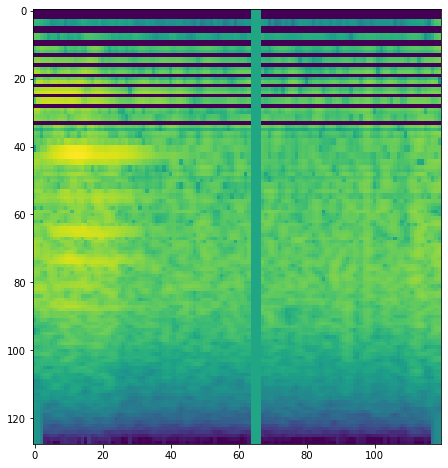

torch.Size([3, 128, 120])

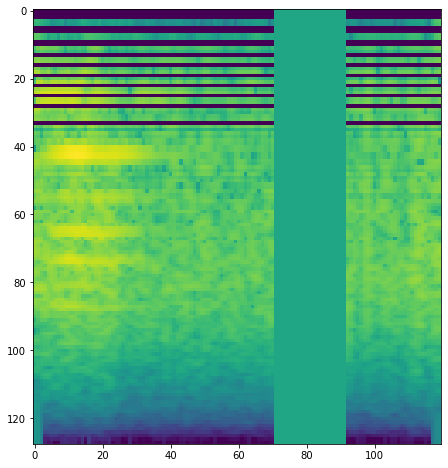

torch.Size([3, 128, 120])

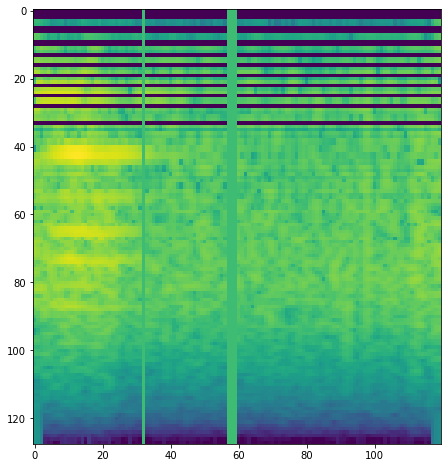

torch.Size([3, 128, 120])

In [108]:
def test_time_mask():
    tensor_to_img(time_mask(spectro))
    # Two Masks...
    tensor_to_img(time_mask(spectro, num_masks=2))
    # with zeros
    tensor_to_img(time_mask(spectro, num_masks=2, replace_with_zero=True))
test_time_mask()

In [109]:
from nb_SparseImageWarp import sparse_image_warp

In [110]:
combined = time_mask(freq_mask(time_warp(spectro), num_masks=2), num_masks=2)
tensor_to_img(combined)

RuntimeError: shape '[3, 128, 120, 2]' is invalid for input of size 30720